## Импорт библиотек + загрузка данных



In [106]:
import numpy as np
import pandas as pd
import datetime
import re

from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from lazypredict.Supervised import LazyRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
import lazypredict
from sklearn.model_selection import cross_validate
import joblib


import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
SEED = 666

In [3]:
macro = pd.read_csv('macro.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1.EDA + заполнение пропусков + работа с выбросами



In [4]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15092 non-null  int64  
 1   timestamp   15092 non-null  object 
 2   full_sq     15092 non-null  int64  
 3   life_sq     13828 non-null  float64
 4   floor       15069 non-null  float64
 5   state       12366 non-null  float64
 6   max_floor   13938 non-null  float64
 7   material    13938 non-null  float64
 8   build_year  13475 non-null  object 
 9   num_room    13938 non-null  float64
 10  kitch_sq    13938 non-null  float64
 11  full_all    15092 non-null  int64  
 12  sub_area    15092 non-null  object 
 13  price_doc   15092 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------

(None, None)

Из явных проблем : 1)Присутствуют нечисловые признаки. 2)Имеется наличие nan-ов


## 1)Приведение всех типов данных к числовым + заполнение пропусков + обработка выбросов

### timestamp

In [5]:
train.timestamp = train.timestamp.apply(lambda x: pd.to_datetime(x))
test.timestamp = test.timestamp.apply(lambda x: pd.to_datetime(x))


<AxesSubplot:>

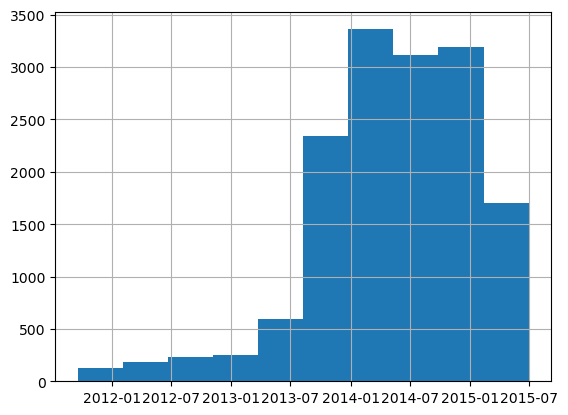

In [6]:
train.timestamp.hist()

<AxesSubplot:>

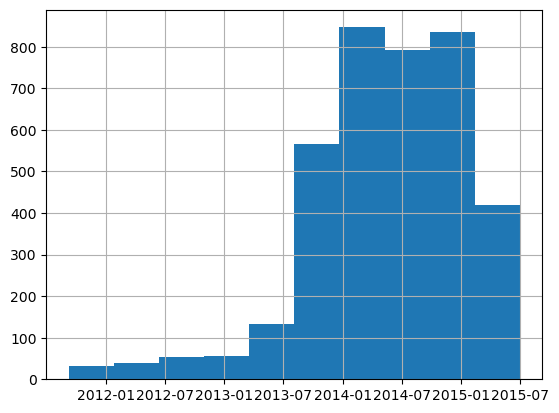

In [7]:
test.timestamp.hist()

Выбросов и аномалий не наблюдается

### build_year

train

In [8]:
train.build_year.unique() #Проверяем всевозможные значения в колонке build_year

array(['1969.0', '1960.0', '1985.0', '2017.0', '2006.0', '1970.0',
       '1986.0', '1984.0', '2013.0', '1980.0', '2014.0', '1993.0',
       '1997.0', '1981.0', '1964.0', '1979.0', '2004.0', '0.0', '1994.0',
       nan, '1972.0', '1.0', '2010.0', '2012.0', '1976.0', '2000.0',
       '1966.0', '2015.0', '1989.0', '1987.0', '1932.0', '1977.0',
       '1983.0', '1962.0', '2008.0', '2003.0', '1965.0', '1990.0',
       '1971.0', '1978.0', '1974.0', '1961.0', '2016.0', '1959.0',
       '1975.0', '1957.0', '1968.0', '1992.0', '1967.0', '1956.0',
       '1995.0', '1988.0', '1958.0', '1973.0', '1999.0', '2005.0',
       '2002.0', '2007.0', '2001.0', '1982.0', '1950.0', '2011.0',
       '1951.0', '1955.0', '1991.0', '1952.0', '1963.0', '2009.0',
       '1998.0', '1890.0', '1954.0', '1927.0', '1917.0', '1930.0',
       '1937.0', '1996.0', '1929.0', '1910.0', '1926.0', '1928.0',
       '1953.0', '1912.0', '1947.0', '1931.0', '1938.0', '1940.0', '20.0',
       '1915.0', '1933.0', '1934.0', '1936.0'

In [9]:
year_build_unique_bad = [x for x in train.build_year.unique() if len(str(x)) < 6 or len(str(x)) > 6]
year_build_unique_bad

['0.0', nan, '1.0', '20.0', '20052009.0', 'o', '215.0', '71.0', '3.0']

In [10]:
sum = 0
for year in year_build_unique_bad:
  values_count = train[train.build_year == year].build_year.count()
  print(f'Плохой "год" - {year}, значений с плохим "годом" {values_count}')
  sum += values_count
print('Кол-во плохих значений всего ' + str(sum))

year_build_median = train[(train.build_year.isin(year_build_unique_bad) == False) & (train.build_year.isnull() == False)].build_year.map(float).median()
year_build_mode = train[train.build_year.isin(year_build_unique_bad) == False].build_year.map(float).mode().iloc[0]
year_build_mean = train[train.build_year.isin(year_build_unique_bad) == False].build_year.map(float).mean()
n = '\n'
print(f'Среднее значение года постройки - {year_build_mean}{n}Мода - {year_build_mode}{n}Медиана - {year_build_median}')

train.build_year = train.build_year.apply(lambda x: year_build_median if x in year_build_unique_bad else float(x))

Плохой "год" - 0.0, значений с плохим "годом" 416
Плохой "год" - nan, значений с плохим "годом" 0
Плохой "год" - 1.0, значений с плохим "годом" 295
Плохой "год" - 20.0, значений с плохим "годом" 1
Плохой "год" - 20052009.0, значений с плохим "годом" 1
Плохой "год" - o, значений с плохим "годом" 1
Плохой "год" - 215.0, значений с плохим "годом" 1
Плохой "год" - 71.0, значений с плохим "годом" 1
Плохой "год" - 3.0, значений с плохим "годом" 1
Кол-во плохих значений всего 717
Среднее значение года постройки - 1985.3288916758113
Мода - 2014.0
Медиана - 1981.0


test


In [11]:
test.build_year.unique() #Проверяем всевозможные значения в колонке build_year

array([      nan, 1.969e+03, 1.970e+03, 2.003e+03, 1.965e+03, 1.966e+03,
       1.928e+03, 1.982e+03, 1.959e+03, 1.978e+03, 1.964e+03, 1.985e+03,
       1.983e+03, 2.004e+03, 1.986e+03, 1.960e+03, 1.952e+03, 1.988e+03,
       1.961e+03, 1.987e+03, 2.014e+03, 1.996e+03, 1.981e+03, 1.976e+03,
       2.010e+03, 1.962e+03, 2.015e+03, 1.984e+03, 1.000e+00, 1.995e+03,
       2.007e+03, 1.974e+03, 2.005e+03, 1.967e+03, 1.939e+03, 2.013e+03,
       1.968e+03, 1.979e+03, 1.973e+03, 2.009e+03, 0.000e+00, 1.963e+03,
       1.972e+03, 1.994e+03, 1.958e+03, 1.998e+03, 1.980e+03, 2.012e+03,
       2.016e+03, 2.008e+03, 1.975e+03, 2.006e+03, 1.971e+03, 1.900e+03,
       1.997e+03, 2.017e+03, 1.935e+03, 1.991e+03, 1.957e+03, 1.977e+03,
       1.924e+03, 1.993e+03, 1.992e+03, 1.917e+03, 1.989e+03, 1.936e+03,
       1.956e+03, 1.915e+03, 1.990e+03, 1.999e+03, 2.002e+03, 1.954e+03,
       2.011e+03, 1.949e+03, 1.912e+03, 2.001e+03, 2.000e+03, 1.933e+03,
       1.955e+03, 1.932e+03, 1.940e+03, 1.926e+03, 

<AxesSubplot:>

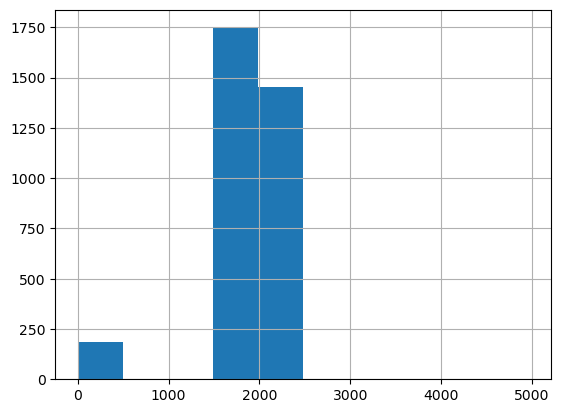

In [12]:
test.build_year.hist() ## Визуализация для поиска выбросов

Видны выбросы в виде экстремально низких значений, а также, раз график построился аж до 5000 значения, то присутсвуют и экстремально высокие значения

Медианный год постройки на тестовых данных - 1982.0


<AxesSubplot:>

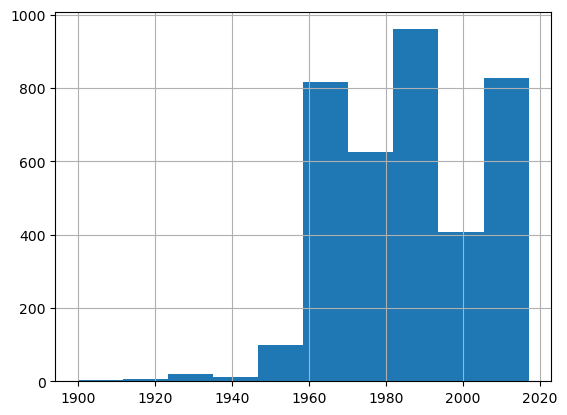

In [13]:
test_year_build_median = test[test.build_year > 1900].build_year.median()
print(f'Медианный год постройки на тестовых данных - {test_year_build_median}')

test.build_year = test.build_year.fillna(test_year_build_median)
test.build_year = test.build_year.apply(lambda x: test_year_build_median if x < 1900 or x > 2023 else x)

test.build_year.hist() ## Визуализация после удаления выбросов

### full_sq

train

In [14]:
train.full_sq.unique()

array([  42,   55,   43,   62,   80,   32,   37,   51,   79,   75,   77,
         36,   38,   73,   59,   34,   90,   30,   44,   66,    1,  117,
         94,  150,   31,   58,   76,   84,   68,   39,   74,  102,   56,
         41,   45,  109,   61,  133,   50,   57,   25,   54,   97,   49,
         33,   47,   52,   35,   46,   82,   63,   88,   72,   67,   89,
         53,   28,   64,   83,   87,  110,   85,  107,  138,   86,   60,
         81,   17,  186,   65,   40,   29,   78,  132,  103,   20,   91,
        120,   48,   71,   69,  134,  101,  106,   98,  104,   27,   99,
        135,   19,  114,   96,  136,   92,   24,   70,  121,   93,  126,
         95,  137,  105,   14,  100,  143,  112,  131,  127,   26,   13,
        170,  119,  124,  144,  113,  116,  160,  139,   12,  123,   18,
        115,  108,  128,  146,  151,  125,   21,  183,  111,  148,   23,
        197,   22,   15,  159,  199,  167,   16,  122,  165,  157,  412,
        142,  219,  176,  129,  155,    0,  158,  2

<AxesSubplot:>

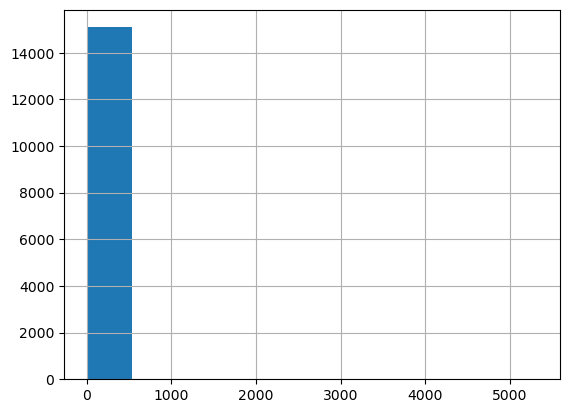

In [15]:
train.full_sq.hist()  ## Визуализация для поиска выбросов

In [16]:
question_full_sq = train[(train.full_sq > 400) | (train.full_sq < 10)]
train = train.drop(question_full_sq.index).reset_index(drop=True)
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000
3,10186,2013-08-30,62,35.00,15.00,NaN,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15062,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000
15063,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,1.00,247469,Nekrasovka,7722400
15064,16165,2014-03-18,38,19.00,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000
15065,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000


<AxesSubplot:>

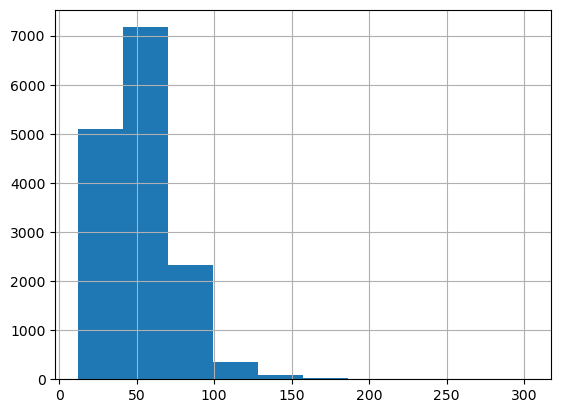

In [17]:
train.full_sq.hist()  ## Визуализация после удаления выбросов

test

In [18]:
test.full_sq.unique()

array([ 51,  44,  32,  31,  37,  33,  64,  34,  28,  41,  66,  77,  73,
        43,  48,  79,  74,  38,  39,  53,  61,  62,  56,  58,  76,  52,
        30,  60,  54,  36, 131,  84,  45,  50,  35,  29,  59,  55,  94,
        72, 106,  75,  40, 118,  87,  65,  67,  57, 151,  63, 121,  78,
        46,  71,  26, 116,  80,  70,  69,  81, 100,  42,  82,  47,  49,
       219, 113,  27,  23,  16, 101,  22, 195, 134,  93, 105,  85,  86,
       148,  18, 103,  97,  95, 102,  68,  99,  25,  88,  96, 138, 112,
       108,  83, 143, 407,  14, 107,  98,  89, 172, 110, 165, 202, 122,
       124, 141,  92, 111,  90,  91, 115, 133, 170,  20, 119, 150, 135,
       161, 129,   1, 117, 184, 146,  15, 114, 187, 155, 154, 183, 160,
       179, 206,  11, 120,   5,  21, 109, 145], dtype=int64)

<AxesSubplot:>

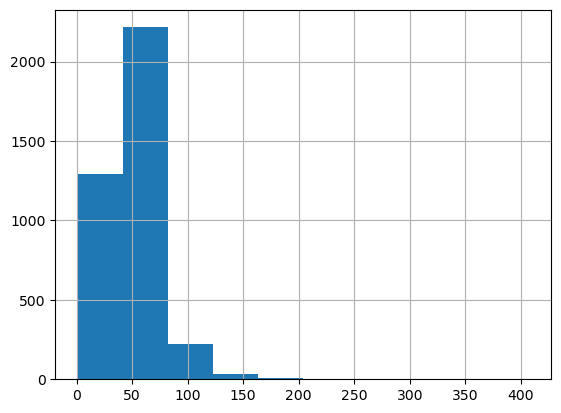

In [19]:
test.full_sq.hist()

### life_sq

train

In [20]:
train.life_sq.unique() #Проверяем всевозможные значения в колонке life_sq

array([ 28.,  41.,  29.,  35.,  55.,  18.,  19.,  40.,  77.,  44.,  75.,
        20.,  32.,  48.,   0.,  46.,  66.,  nan,  43.,  52.,  80.,  37.,
        45.,  62.,  30.,  23.,  63.,  34.,  50.,  22.,  36.,  79.,  74.,
        14.,  42.,  31.,  59.,  69.,  27.,  47.,   1.,  15.,  17.,  51.,
        54.,  21.,  73.,  16.,  64.,  38.,  33., 107.,  89.,  39.,  26.,
        76.,  70.,  49.,  81.,  53.,  13.,  60.,  86.,  56.,  57.,  58.,
       103.,  87.,  82.,  93.,  71., 134.,  10.,  83.,  25.,  24.,  61.,
        12.,  96.,  65.,  94.,  85., 121.,  78., 136.,  68.,  91., 104.,
         8., 112., 108., 458., 102., 113., 349., 160.,   9.,  67.,   7.,
        72.,  11., 435., 146.,  98., 125.,  97., 148., 114.,  95.,  88.,
       197.,  84., 101., 159., 116., 157.,  99., 122., 163., 100., 259.,
       133., 158., 117., 165., 120., 110., 115., 126., 179., 123.,  90.,
       232.,  92., 139., 149., 144., 106., 118., 124., 209., 301., 105.,
       174., 138., 119., 162., 145., 176., 142., 16

<AxesSubplot:>

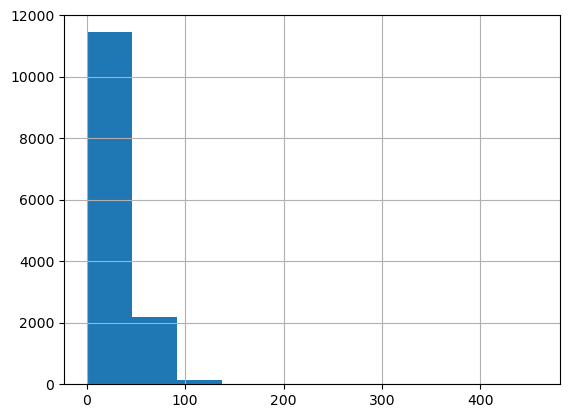

In [21]:
train.life_sq.hist()  ## Визуализация для поиска выбросов

In [22]:
train.life_sq.isnull().value_counts()

False    13803
True      1264
Name: life_sq, dtype: int64

Заполним пропуски значением, которое определяется 80% площади full_sq


In [23]:
for i in range(train.life_sq.shape[0]):
  if train.life_sq.iloc[i] < 20:
    train.at[i, 'life_sq'] = train.at[i, 'full_sq'] * 0.8  ## заменим экстремально низкие значения

In [24]:
train.life_sq.fillna(train.full_sq * 0.8,inplace=True)
train.life_sq.isnull().value_counts()

False    15067
Name: life_sq, dtype: int64

test

In [25]:
test.life_sq.unique() #Проверяем всевозможные значения в колонке life_sq

array([3.100e+01, 2.900e+01, 1.800e+01, 3.000e+01, 2.800e+01, 2.100e+01,
       1.700e+01,       nan, 4.300e+01, 1.900e+01, 4.400e+01, 1.100e+01,
       2.600e+01, 4.600e+01, 3.800e+01, 2.700e+01, 1.400e+01, 4.100e+01,
       2.000e+01, 3.200e+01, 5.100e+01, 3.300e+01, 5.800e+01, 4.500e+01,
       1.000e+00, 3.400e+01, 2.300e+01, 1.180e+02, 2.400e+01, 8.400e+01,
       4.200e+01, 7.400e+01, 3.700e+01, 5.200e+01, 1.600e+01, 5.600e+01,
       3.900e+01, 5.500e+01, 6.700e+01, 5.900e+01, 7.600e+01, 2.500e+01,
       8.200e+01, 3.500e+01, 6.200e+01, 1.500e+01, 5.400e+01, 4.700e+01,
       5.000e+01, 7.700e+01, 6.600e+01, 3.600e+01, 9.000e+00, 7.000e+01,
       4.800e+01, 6.100e+01, 2.200e+01, 4.900e+01, 4.000e+01, 6.400e+01,
       6.300e+01, 7.800e+01, 5.700e+01, 5.300e+01, 6.800e+01, 8.100e+01,
       1.190e+02, 7.200e+01, 7.300e+01, 9.700e+01, 8.500e+01, 6.000e+01,
       8.600e+01, 6.500e+01, 7.900e+01, 9.500e+01, 8.700e+01, 9.000e+01,
       0.000e+00, 7.500e+01, 1.030e+02, 8.000e+01, 

In [26]:
test.life_sq.describe()

count   3463.00
mean      36.15
std      127.97
min        0.00
25%       20.00
50%       30.00
75%       43.00
max     7478.00
Name: life_sq, dtype: float64

<AxesSubplot:>

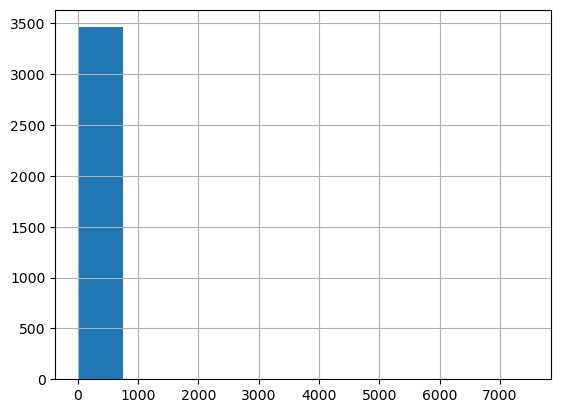

In [27]:
test.life_sq.hist()  ## Визуализация для поиска выбросов

Очевидны выбросы

In [28]:
test[test.life_sq > 100]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area
58,15699,2014-03-04,131,118.00,10.00,1.00,39.00,4.00,2009.00,1.00,3.00,116742,Tverskoe
272,17713,2014-04-22,219,118.00,31.00,1.00,48.00,4.00,2010.00,3.00,4.00,102726,Jakimanka
363,28958,2015-04-07,195,119.00,1.00,1.00,2.00,4.00,2010.00,5.00,10.00,5740,Poselenie Pervomajskoe
908,29436,2015-04-27,103,103.00,15.00,1.00,25.00,6.00,1982.00,4.00,12.00,7341,Poselenie Moskovskij
968,27796,2015-02-09,407,407.00,4.00,1.00,4.00,4.00,2015.00,1.00,10.00,112804,Filevskij Park
1331,6002,2013-02-12,165,165.00,11.00,NaN,NaN,NaN,1982.00,NaN,NaN,90114,Teplyj Stan
1351,28700,2015-03-30,101,101.00,10.00,1.00,10.00,1.00,1982.00,3.00,1.00,13890,Poselenie Sosenskoe
1416,19931,2014-06-21,124,124.00,24.00,1.00,24.00,1.00,2015.00,3.00,19.00,81887,Hovrino
1438,24720,2014-11-13,141,141.00,3.00,1.00,3.00,4.00,2012.00,3.00,10.00,143661,Troickij okrug
1520,26869,2014-12-19,111,111.00,11.00,1.00,15.00,6.00,2016.00,3.00,17.00,7341,Poselenie Moskovskij


Нашелся один такой выброс с life_sq 7478.00, очевидно опечатка, просто поделим это значение на 100, учитывая full_sq 78

In [29]:
test.life_sq = test.life_sq.replace([7478.00], 7478.00/100)

In [30]:
test.iloc[1746].life_sq

74.78

<AxesSubplot:>

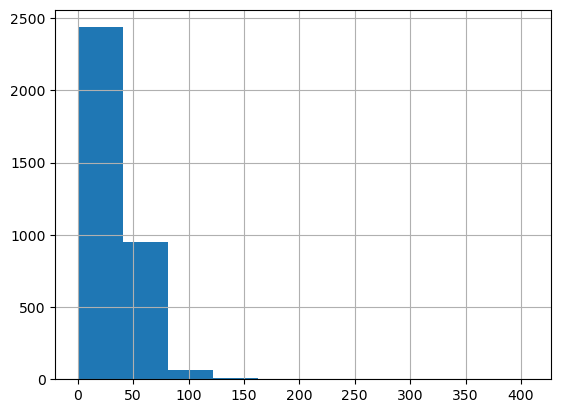

In [31]:
test.life_sq.hist()  ## Визуализация после работы над выбросами

In [32]:
test.life_sq.fillna(test.full_sq * 0.8,inplace=True)
test.life_sq.isnull().value_counts()

False    3774
Name: life_sq, dtype: int64

### floor

train

In [33]:
train.floor.unique() #Проверяем всевозможные значения в колонке floor

array([ 8.,  4., 15., 19.,  1.,  7.,  6.,  5.,  9., 10., 11., 12.,  3.,
       16., 13., 20., 22.,  2., 14., 18., 23., 17., 37., 26., 24., nan,
       25., 21., 27., 34., 28., 77., 41., 32., 31., 33.,  0., 36., 30.,
       44.])

In [34]:
train[train.floor == 44]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
13138,30314,2015-06-18,65,39.00,44.00,4.00,48.00,4.00,2000.00,2.00,5.00,102726,Jakimanka,8857680


Учитывая Max_floor не похоже, чтобы это значение было выбросом

In [35]:
train.floor.median()

6.0

In [36]:
train.floor.fillna(train.floor.median(),inplace=True)

test

In [37]:
test.floor.fillna(test.floor.median(),inplace=True)

### state


train

In [38]:
train.state.unique()

array([ 2.,  3., nan,  1.,  4., 33.])

<AxesSubplot:>

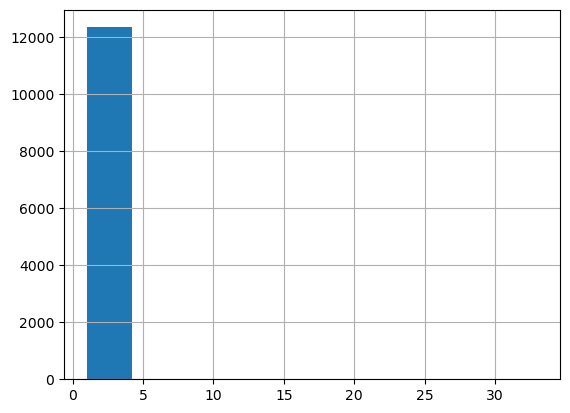

In [39]:
train.state.hist()

Выбросы очевидны

In [40]:
train.state.mode(), train.state.median() 

(0   2.00
 Name: state, dtype: float64,
 2.0)

не прогадаем если заполним nan-ы на 2.0

In [41]:
train.state = train.state.replace([33.00], 2.0)

In [42]:
train.state.fillna(2.0,inplace=True)

test

In [43]:
test.state.unique()

array([nan,  3.,  1.,  2.,  4.])

In [44]:
test.state.mode(), test.state.median() 

(0   3.00
 Name: state, dtype: float64,
 2.0)

Категориальные пропуски принято заполнять модой

In [45]:
test.state.fillna(3.0,inplace=True)

### max_floor

train

In [46]:
train.max_floor.unique()

array([ 9.,  5., 22., 24., 23., 17., 16.,  6., 14., 12., 20., nan, 27.,
        0., 13., 25., 40., 18., 10.,  1.,  8.,  2., 19.,  4.,  3., 15.,
       38., 30., 21.,  7., 36., 29., 26., 32., 11., 28., 37., 39., 34.,
       48., 47., 41., 57., 42., 33., 31.])

In [47]:
train[train.max_floor > 40]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
4073,21609,2014-08-18,74,38.00,41.00,3.00,48.00,4.00,2013.00,2.00,5.00,102726,Jakimanka,14500000
4308,15108,2014-02-17,126,103.00,20.00,1.00,47.00,4.00,2012.00,1.00,14.00,61039,Ramenki,16000000
4317,29712,2015-05-14,116,98.00,11.00,1.00,41.00,4.00,2011.00,1.00,8.00,116742,Tverskoe,3700000
8422,26668,2014-12-17,126,98.00,31.00,1.00,48.00,6.00,2003.00,1.00,17.00,166803,Shhukino,41500000
9552,24023,2014-10-28,135,59.00,9.00,4.00,57.00,4.00,2007.00,3.00,22.00,80791,Horoshevskoe,56500000
11290,19420,2014-06-06,71,38.00,36.00,3.00,48.00,4.00,2010.00,2.00,5.00,102726,Jakimanka,18700000
11691,18865,2014-05-26,94,79.00,18.00,1.00,42.00,4.00,2010.00,1.00,4.00,116742,Tverskoe,5588313
13138,30314,2015-06-18,65,39.00,44.00,4.00,48.00,4.00,2000.00,2.00,5.00,102726,Jakimanka,8857680
13675,20490,2014-07-01,125,74.00,34.00,1.00,48.00,4.00,2011.00,3.00,17.00,155427,Horoshevo-Mnevniki,16200000


Не похоже на выбросы

In [48]:
train.max_floor.median()

12.0

Заполним пропуски медианным значением

In [49]:
train.max_floor.fillna(train.max_floor.median(),inplace=True)

test

In [50]:
test.max_floor.median()

12.0

In [51]:
test.max_floor.fillna(test.max_floor.median(),inplace=True)

### material

train

In [52]:
train.material.unique()

array([ 1.,  2.,  6.,  4.,  5., nan,  3.])

In [53]:
train.material.mode()

0   1.00
Name: material, dtype: float64

In [54]:
train.material.fillna(1.00,inplace=True)

test

In [55]:
test.material.unique()

array([nan,  1.,  5.,  2.,  4.,  6.])

In [56]:
test.material.mode()

0   1.00
Name: material, dtype: float64

In [57]:
test.material.fillna(1.00,inplace=True)

### num_rum

train

In [58]:
train.num_room.unique()

array([ 2.,  3.,  1., nan,  4., 10.,  6.,  5.,  0., 17., 19.,  9.,  8.])

Средняя площадь комнаты в мск - 17.3 кв.м., применим это значение для замены в выбросах

In [59]:
for i in range(train.num_room.shape[0]):
  if train.num_room.iloc[i] > 8 or pd.isnull(train.num_room.iloc[i]):
    train.at[i, 'num_room'] = int(train.at[i, 'life_sq'] / 17.3)  ## заменяем количество комнат на число, которое определяется как жилая площадь деленная на ср. площадь комнаты мск.

In [60]:
train.num_room = train.num_room.apply(lambda x : 1 if x == 0 else x) ## заменим нулевые значения на единицу

test

In [61]:
test.num_room.unique()

array([nan,  2.,  1.,  3.,  4.,  0.,  5.,  6.,  8.,  7.])

In [62]:
for i in range(test.num_room.shape[0]):
  if test.num_room.iloc[i] > 8 or pd.isnull(test.num_room.iloc[i]):
    test.at[i, 'num_room'] = int(test.at[i, 'life_sq'] / 17.3)  ## заменяем количество комнат на число, которое определяется как жилая площадь деленная на ср. площадь комнаты мск.

test.num_room = test.num_room.apply(lambda x : 1 if x == 0 else x) ## заменим нулевые значения на единицу

### kitch_sq

train

In [63]:
train.kitch_sq.unique()

array([6.000e+00, 5.000e+00, 1.000e+01, 1.200e+01, 7.000e+00, 9.000e+00,
       1.000e+00, 1.100e+01, 8.000e+00, 0.000e+00,       nan, 2.500e+01,
       4.000e+00, 1.400e+01, 2.400e+01, 1.600e+01, 1.700e+01, 4.200e+01,
       3.700e+01, 3.200e+01, 1.300e+01, 1.800e+01, 1.900e+01, 3.000e+00,
       2.000e+01, 6.100e+01, 4.000e+01, 1.500e+01, 4.300e+01, 3.300e+01,
       1.120e+02, 2.300e+01, 6.300e+01, 2.800e+01, 2.000e+00, 4.100e+01,
       2.100e+01, 3.000e+01, 2.200e+01, 9.600e+01, 3.900e+01, 2.014e+03,
       4.800e+01, 5.800e+01, 3.600e+01, 5.100e+01, 1.230e+02, 2.600e+01,
       6.200e+02, 8.600e+01, 7.200e+01, 5.300e+01, 3.100e+01, 6.000e+01,
       4.400e+01, 3.400e+01, 8.400e+01, 1.974e+03, 2.900e+01, 6.600e+01,
       6.500e+01, 2.700e+01, 5.700e+01, 2.013e+03])

<AxesSubplot:>

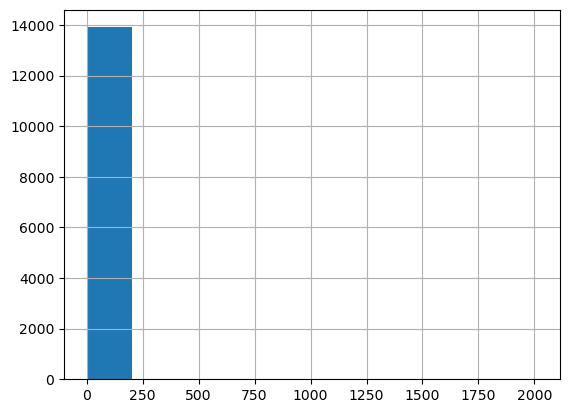

In [64]:
train.kitch_sq.hist()

In [65]:
train[train.kitch_sq > 25].kitch_sq.count() ## смотрим на количество значений с аномальной площадью

58

По своду правил минимальная площадь кухни - 8кв.м.

In [66]:
train.kitch_sq = train.kitch_sq.apply(lambda x: 8.0 if x <= 8 or pd.isnull(x) == True else x) ## заполняем пропуски и несоответствующие значения нормативным значением

In [67]:
question_kitch_sq = train[train.kitch_sq > 25]
train = train.drop(question_kitch_sq.index).reset_index(drop=True) ## избавляемся от выбросов

<AxesSubplot:>

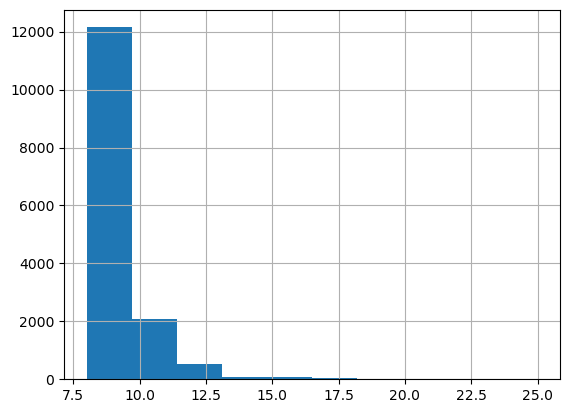

In [68]:
train.kitch_sq.hist()

test

In [69]:
test.kitch_sq.unique()

array([nan,  5.,  6.,  9.,  0.,  8.,  7.,  4., 10., 12.,  1., 13., 62.,
        3., 11., 16., 14., 19., 15., 33., 23.,  2., 20., 18., 24., 35.,
       22., 37., 17., 78., 51., 97., 31., 54., 74., 39., 32., 57., 95.,
       29., 60., 73.])

In [70]:
test[test.kitch_sq > 15]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area
51,15973,2014-03-13,62,33.00,1.00,1.00,7.00,1.00,2014.00,1.00,62.00,12061,Poselenie Krasnopahorskoe
129,16955,2014-04-03,57,25.00,5.00,3.00,17.00,4.00,2006.00,1.00,16.00,41504,Beskudnikovskoe
148,21152,2014-07-29,121,62.00,19.00,4.00,23.00,4.00,2007.00,3.00,19.00,123000,Kon'kovo
279,21102,2014-07-25,113,64.00,8.00,3.00,16.00,4.00,2009.00,3.00,16.00,7538,Poselenie Kokoshkino
357,12248,2013-11-18,22,14.00,3.00,1.00,5.00,2.00,1970.00,1.00,33.00,1452550,Bogorodskoe
395,22106,2014-09-02,105,52.00,25.00,3.00,25.00,4.00,2009.00,3.00,16.00,125111,Solncevo
421,12560,2013-11-27,66,36.00,6.00,1.00,17.00,6.00,2012.00,2.00,16.00,13890,Poselenie Sosenskoe
431,20222,2014-06-26,148,97.00,6.00,4.00,7.00,2.00,1912.00,4.00,23.00,28179,Basmannoe
774,29281,2015-04-21,108,90.00,12.00,1.00,24.00,6.00,2017.00,4.00,20.00,76284,Nagatinskij Zaton
839,30106,2015-06-03,87,32.00,3.00,3.00,18.00,2.00,2013.00,2.00,18.00,111023,Ochakovo-Matveevskoe


In [71]:
test.kitch_sq = test.kitch_sq.apply(lambda x: 8.0 if x <= 8 or pd.isnull(x) == True or x >= 15 else x) ## заполняем пропуски и несоответствующие значения нормативным значением

### Приведение значений sub_area к числовому типу

In [72]:
le = LabelEncoder()

le.fit(train.sub_area.unique())
train.sub_area = le.transform(train.sub_area)
test.sub_area = le.transform(test.sub_area)

### итог

In [73]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15009 entries, 0 to 15008
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          15009 non-null  int64         
 1   timestamp   15009 non-null  datetime64[ns]
 2   full_sq     15009 non-null  int64         
 3   life_sq     15009 non-null  float64       
 4   floor       15009 non-null  float64       
 5   state       15009 non-null  float64       
 6   max_floor   15009 non-null  float64       
 7   material    15009 non-null  float64       
 8   build_year  15009 non-null  float64       
 9   num_room    15009 non-null  float64       
 10  kitch_sq    15009 non-null  float64       
 11  full_all    15009 non-null  int64         
 12  sub_area    15009 non-null  int32         
 13  price_doc   15009 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int32(1), int64(4)
memory usage: 1.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeI

(None, None)

с пропусками и выбросами разобрались

## 2)Добавление колонок из таблицы macro в исходные датафреймы

In [74]:
macro.timestamp = macro.timestamp.apply(lambda x: pd.to_datetime(x))
macro

,timestamp,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,2010-01-01,38410.50,11443.63,NaN,NaN,NaN,74.20
1,2010-01-02,38410.50,11443.63,NaN,NaN,NaN,74.20
2,2010-01-03,38410.50,11443.63,NaN,NaN,NaN,74.20
3,2010-01-04,38410.50,11443.63,NaN,NaN,NaN,74.20
4,2010-01-05,38410.50,11443.63,NaN,NaN,NaN,74.20
...,...,...,...,...,...,...,...
2479,2016-10-15,NaN,20354.78,45.71,38.40,29.78,NaN
2480,2016-10-16,NaN,20354.78,45.71,38.40,29.78,NaN
2481,2016-10-17,NaN,20354.78,45.71,38.40,29.78,NaN
2482,2016-10-18,NaN,20354.78,45.71,38.40,29.78,NaN


### salary

train

In [244]:
train['salary'] = train.build_year
for i in range(train.build_year.shape[0]):
  train.at[i, 'salary'] = macro[macro.timestamp == train.timestamp.iloc[i]].salary.iloc[0] ##метчим по дате транзакции и дате, для которой актуальны макро показатели

test


In [76]:
test['salary'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'salary'] = macro[macro.timestamp == test.timestamp.iloc[i]].salary.iloc[0]

### fixed_basket

train

In [77]:
train['fixed_basket'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'fixed_basket'] = macro[macro.timestamp == train.timestamp.iloc[i]].fixed_basket.iloc[0]

test

In [78]:
test['fixed_basket'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'fixed_basket'] = macro[macro.timestamp == test.timestamp.iloc[i]].fixed_basket.iloc[0]

### rent_price_3room_eco

train

In [79]:
train['rent_price_3room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_3room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_3room_eco.iloc[0]

test

In [80]:
test['rent_price_3room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_3room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_3room_eco.iloc[0]

### rent_price_2room_eco

train

In [81]:
train['rent_price_2room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_2room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_2room_eco.iloc[0]

test

In [82]:
test['rent_price_2room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_2room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_2room_eco.iloc[0]

### rent_price_1room_eco

train

In [83]:
train['rent_price_1room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_1room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_1room_eco.iloc[0]

test

In [84]:
test['rent_price_1room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_1room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_1room_eco.iloc[0]

### average_life_exp

train

In [85]:
train['average_life_exp'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'average_life_exp'] = macro[macro.timestamp == train.timestamp.iloc[i]].average_life_exp.iloc[0]

test

In [86]:
test['average_life_exp'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'average_life_exp'] = macro[macro.timestamp == test.timestamp.iloc[i]].average_life_exp.iloc[0]

### Итог

In [87]:
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,8.00,43795,83,7100000,55485.20,15417.34,48.50,42.00,33.97,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,8.00,21040,23,11500000,55485.20,15241.93,48.22,42.33,33.15,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,8.00,157010,33,5800000,55485.20,15367.58,49.29,42.02,34.55,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,37,11400000,55485.20,15241.93,48.22,42.33,33.15,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,70,12697154,64310.00,18745.28,50.42,39.16,31.09,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15004,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,8.00,101982,129,9100000,61208.00,16269.79,52.82,43.85,35.37,76.70
15005,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,8.00,247469,72,7722400,61208.00,16269.79,52.82,43.85,35.37,76.70
15006,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,41,7000000,61208.00,15916.88,49.75,41.91,33.26,76.70
15007,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,37,7000000,55485.20,15215.84,49.12,42.10,34.53,76.37


In [88]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15009 entries, 0 to 15008
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    15009 non-null  int64         
 1   timestamp             15009 non-null  datetime64[ns]
 2   full_sq               15009 non-null  int64         
 3   life_sq               15009 non-null  float64       
 4   floor                 15009 non-null  float64       
 5   state                 15009 non-null  float64       
 6   max_floor             15009 non-null  float64       
 7   material              15009 non-null  float64       
 8   build_year            15009 non-null  float64       
 9   num_room              15009 non-null  float64       
 10  kitch_sq              15009 non-null  float64       
 11  full_all              15009 non-null  int64         
 12  sub_area              15009 non-null  int32         
 13  price_doc       

(None, None)

# 2.Модификация существующих признаков

## Изменение типов признаков для увеличения скорости обработки


train

In [89]:
train.head(10)

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,8.00,43795,83,7100000,55485.20,15417.34,48.50,42.00,33.97,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,8.00,21040,23,11500000,55485.20,15241.93,48.22,42.33,33.15,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,8.00,157010,33,5800000,55485.20,15367.58,49.29,42.02,34.55,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,37,11400000,55485.20,15241.93,48.22,42.33,33.15,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,70,12697154,64310.00,18745.28,50.42,39.16,31.09,76.77
5,10073,2013-08-26,42,33.60,19.00,2.00,23.00,1.00,2006.00,1.00,10.00,83369,110,2000000,55485.20,15241.93,48.22,42.33,33.15,76.37
6,23912,2014-10-24,32,25.60,1.00,3.00,9.00,1.00,1970.00,1.00,8.00,145576,15,5700000,61208.00,16269.79,52.82,43.85,35.37,76.70
7,21173,2014-07-30,37,29.60,7.00,3.00,17.00,1.00,1986.00,1.00,8.00,123000,43,7850000,61208.00,16251.41,50.93,41.97,33.67,76.70
8,24816,2014-11-17,51,40.00,6.00,4.00,9.00,1.00,1969.00,3.00,8.00,157010,33,9500000,61208.00,16648.70,53.21,43.23,34.30,76.70
9,17345,2014-04-14,37,29.60,5.00,3.00,16.00,1.00,1984.00,1.00,9.00,1318695,141,6100000,61208.00,16041.58,49.32,40.95,32.96,76.70


Из здравого смысла и проанализировав таблицу выше, можно понять, что можно изменить тип колонок floor, state, max_floor, material, build_year, num_room с float на int16

In [90]:
int_8_cols = ['floor', 'state', 'max_floor', 'material','num_room']
train[int_8_cols] = train[int_8_cols].applymap(np.int8)
train.build_year = train.build_year.map(np.int16)

test

In [98]:
test[int_8_cols] = test[int_8_cols].applymap(np.int8)
test.build_year = test.build_year.map(np.int16)

## Стандартизация данных

In [112]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.drop(['price_doc','timestamp'], 1))

X = scaled_train
y = train['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.18)

# 3.Применение моделей

In [149]:
regressors = {
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=7),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=SEED),
    'RandomForestRegressor': RandomForestRegressor(random_state=SEED),
    'MLPRegressor': MLPRegressor(random_state=SEED),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=SEED),
    'XGBRegressor': XGBRegressor(random_state=SEED),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=SEED),
    'CatBoostRegressor': CatBoostRegressor(random_seed = SEED, verbose=False),
}

In [ ]:
df = pd.DataFrame(columns=['regressor','MAE'])
for name, model in regressors.items():
    print(name)
    regressor = model
    regressor.fit(X_train, np.ravel(y_train))
    predicts = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, predicts)
    df = df.append({'regressor': name,'MAE': mae}, ignore_index=True)
    
df.sort_values(by=['MAE'],ascending = True)

,regressor,MAE
7,CatBoostRegressor,1562862.01
5,XGBRegressor,1631709.16
2,RandomForestRegressor,1698597.65
6,GradientBoostingRegressor,1775433.53
0,KNeighborsRegressor,2173385.47
1,DecisionTreeRegressor,2387352.70
4,AdaBoostRegressor,2578535.28
8,lg,4014404.93
3,MLPRegressor,7486212.99


CatBoost снова на высоте

## CatBoost + стандартизация

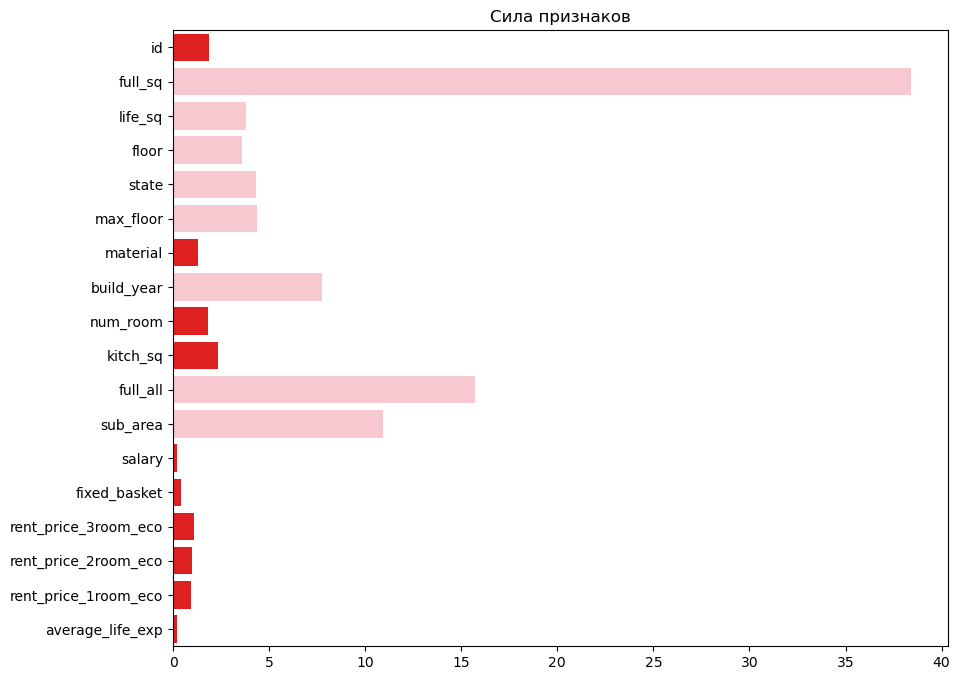

In [137]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.drop(['price_doc','timestamp'], 1))

X = scaled_train
y = train['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.18)

clf = CatBoostRegressor(random_seed = SEED, verbose=False)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = train.drop(['price_doc','timestamp'], 1).columns
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

### Отбор признаков

In [136]:
strong_features = [key for key,value in dict(zip(train.drop(['price_doc','timestamp'], 1).columns, clf.feature_importances_ )).items() if value > 2]
strong_features

['full_sq',
 'life_sq',
 'floor',
 'state',
 'max_floor',
 'build_year',
 'kitch_sq',
 'full_all',
 'sub_area']

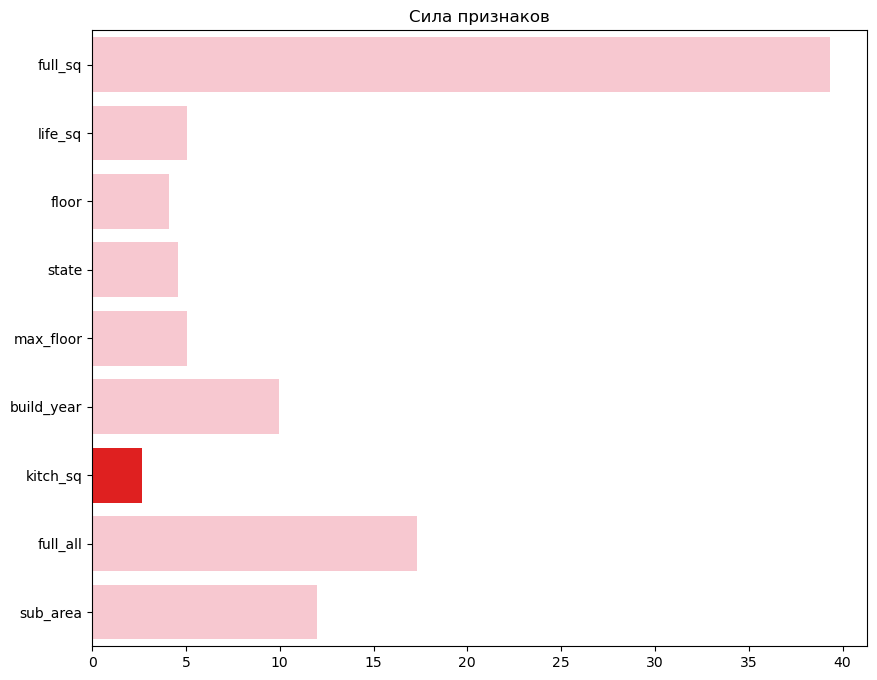

In [147]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[strong_features])

X = scaled_train
y = train['price_doc']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED, test_size=0.18)

clf = CatBoostRegressor(random_seed = SEED, verbose=False)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = train[strong_features].columns
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [150]:
df = pd.DataFrame(columns=['regressor','MAE'])
for name, model in regressors.items():
    print(name)
    regressor = model
    regressor.fit(X_train, np.ravel(y_train))
    predicts = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, predicts)
    df = df.append({'regressor': name,'MAE': mae}, ignore_index=True)
    
df.sort_values(by=['MAE'],ascending = True)

KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor
MLPRegressor
AdaBoostRegressor
XGBRegressor
GradientBoostingRegressor
CatBoostRegressor


,regressor,MAE
7,CatBoostRegressor,1587563.19
5,XGBRegressor,1626108.14
2,RandomForestRegressor,1696246.79
6,GradientBoostingRegressor,1774673.51
0,KNeighborsRegressor,2090948.26
1,DecisionTreeRegressor,2402018.42
4,AdaBoostRegressor,2817160.79
3,MLPRegressor,7500422.39


Отбор признаков ухудшил показатели

### CatBoost без стандартизации

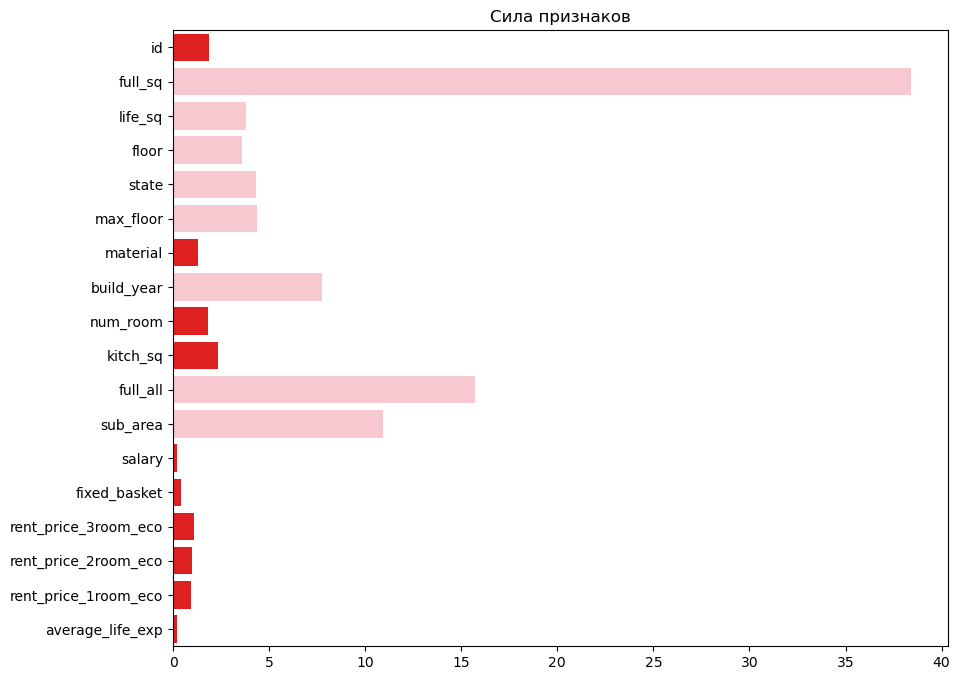

In [151]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc','timestamp'], 1), train.price_doc, random_state = SEED, test_size=0.18)

clf = CatBoostRegressor(random_seed = SEED, verbose=False)
clf = clf.fit(X_train, np.ravel(y_train))

values = clf.feature_importances_   
idx = train.drop(['price_doc','timestamp'], 1).columns
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [152]:
df = pd.DataFrame(columns=['regressor','MAE'])
for name, model in regressors.items():
    print(name)
    regressor = model
    regressor.fit(X_train, np.ravel(y_train))
    predicts = regressor.predict(X_test)
    mae = mean_absolute_error(y_test, predicts)
    df = df.append({'regressor': name,'MAE': mae}, ignore_index=True)
    
df.sort_values(by=['MAE'],ascending = True)

KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor
MLPRegressor
AdaBoostRegressor
XGBRegressor
GradientBoostingRegressor
CatBoostRegressor


,regressor,MAE
7,CatBoostRegressor,1562862.01
5,XGBRegressor,1631451.97
2,RandomForestRegressor,1698758.22
6,GradientBoostingRegressor,1775994.83
1,DecisionTreeRegressor,2390465.73
4,AdaBoostRegressor,2557590.27
0,KNeighborsRegressor,2870989.42
3,MLPRegressor,2965402.85


На CatBoost стандартизация не дала прироста

## Эксперимент

In [163]:
X_train, X_test, y_train, y_test = train_test_split(train[strong_features], train.price_doc, random_state = SEED, test_size=0.18)

Model = []
MAE = []
cv = KFold(5, random_state = SEED, shuffle=True)

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    MAE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, 
                                               scoring='neg_mean_squared_error').mean()))

In [164]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)

names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
         'K Neighbors Regressor', 'Decision Tree Regressor', 
         'Random Forest Regressor', 'Gradient Boosting Regressor',
         'Adaboost Regressor','CatBoostRegressor']
models = [LinearRegression(), Ridge(), Lasso(),
          KNeighborsRegressor(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(),CatBoostRegressor(verbose=False)]

#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, X_train, y_train)

In [165]:
evaluation = pd.DataFrame({'Model': Model,
                           'MAE': MAE})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation.sort_values(by=['MAE'])

FOLLOWING ARE THE TRAINING SCORES: 


,Model,MAE
8,CatBoostRegressor,2956665.37
5,Random Forest Regressor,3152867.01
6,Gradient Boosting Regressor,3173655.46
3,K Neighbors Regressor,3385874.84
1,Ridge Regression,3618641.29
0,Linear Regression,3618641.37
2,Lasso Regression,3618641.37
7,Adaboost Regressor,3965030.57
4,Decision Tree Regressor,4305686.12


С кроссвалидацией показатели значительно хуже, есть вероятность переобучения

# Первый сабмит

In [182]:
cat_clf = CatBoostRegressor(random_state=SEED, verbose=False)
cat_clf.fit(train.drop(['price_doc','timestamp'],axis = 1),train['price_doc'])

test['price_doc']=cat_clf.predict(test.drop(['timestamp'],axis = 1))
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_1.csv', index=None)


1656650.39351 скор


# 4.Улучшение модели

## Сабмит с сильными признаками 1


In [186]:
strong_features

['full_sq',
 'life_sq',
 'floor',
 'state',
 'max_floor',
 'build_year',
 'kitch_sq',
 'full_all',
 'sub_area']

In [188]:
cat_clf = CatBoostRegressor(random_state=SEED, verbose=False)
cat_clf.fit(train[strong_features],train['price_doc'])

test['price_doc']=cat_clf.predict(test[strong_features])
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_2_strong.csv', index=None)

1632337.49585 прирост в 20 000

## Сабмит с сильными признаками 2

In [190]:
strong_features_2 = [key for key,value in dict(zip(train.drop(['price_doc','timestamp'], 1).columns, clf.feature_importances_ )).items() if value > 4]
strong_features_2

['full_sq', 'state', 'max_floor', 'build_year', 'full_all', 'sub_area']

In [191]:
cat_clf = CatBoostRegressor(random_state=SEED, verbose=False)
cat_clf.fit(train[strong_features_2],train['price_doc'])

test['price_doc']=cat_clf.predict(test[strong_features_2])
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_3_strong.csv', index=None)

1620423.95075 прирост в 12 000


## подбор гиперпараметров

### со всеми признаками

In [217]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc','timestamp'], 1), train.price_doc, random_state = SEED, test_size=0.18)

In [218]:


def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [1100, 1150, 1200, 1250, 1300]), 
        'verbose': 0, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'early_stopping_rounds' : 3000,
        'eval_metric': 'MAE',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

In [219]:
# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-03-21 13:01:13,026] A new study created in memory with name: no-name-5dcec492-1da9-4196-95ba-4cd0b0bec738
[I 2023-03-21 13:01:16,167] Trial 0 finished with value: 1436157.9818560884 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1436157.9818560884.
[I 2023-03-21 13:01:20,076] Trial 1 finished with value: 1489936.355553364 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1436157.9818560884.
[I 2023-03-21 13:01:24,000] Trial 2 finished with value: 1452570.6433443006 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 1436157.9818560884.
[I 2023-03-21 13:01:28,233] Trial 3 finished with value: 1452294.643501075 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7

Параметры, полученные при лучшей оценке: {'iterations': 1200, 'l2_leaf_reg': 5.282663586156693, 'learning_rate': 0.15, 'max_depth': 5}


In [230]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=False)
cat_clf.fit(train.drop(['price_doc','timestamp'],axis = 1),train['price_doc'])

test['price_doc']=cat_clf.predict(test.drop(['timestamp'],axis = 1))
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_4.csv', index=None)

1806589.89836 модель значительно ухудшилась

### С сильными признаками 1

In [241]:
X_train, X_test, y_train, y_test = train_test_split(train[strong_features], train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [1100, 1150, 1200, 1250, 1300]), 
        'verbose': 0, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'early_stopping_rounds' : 3000,
        'eval_metric': 'MAE',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-03-21 13:20:00,283] A new study created in memory with name: no-name-2ce9bf43-2f48-42f0-8be6-7b063b1cbcde
[I 2023-03-21 13:20:03,211] Trial 0 finished with value: 1466311.1881227917 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1466311.1881227917.
[I 2023-03-21 13:20:06,888] Trial 1 finished with value: 1511731.8373303816 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1466311.1881227917.
[I 2023-03-21 13:20:10,379] Trial 2 finished with value: 1451524.645384084 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 2 with value: 1451524.645384084.
[I 2023-03-21 13:20:14,201] Trial 3 finished with value: 1456619.629768042 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}

Параметры, полученные при лучшей оценке: {'iterations': 1250, 'l2_leaf_reg': 5.248110834214657, 'learning_rate': 0.1, 'max_depth': 7}


In [242]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=250)
cat_clf.fit(train[strong_features],train['price_doc'])

test['price_doc']=cat_clf.predict(test[strong_features])
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_8.csv', index=None)

0:	learn: 4735513.2354191	total: 3.84ms	remaining: 4.79s
250:	learn: 2381635.6208952	total: 828ms	remaining: 3.29s
500:	learn: 2130710.0129819	total: 1.7s	remaining: 2.55s
750:	learn: 1960487.2525996	total: 2.51s	remaining: 1.67s
1000:	learn: 1835309.2349514	total: 3.33s	remaining: 828ms
1249:	learn: 1737511.3974273	total: 4.2s	remaining: 0us


1650381.32879 хуже чем до подбора параметров

## С сильными признаками 2

In [243]:
X_train, X_test, y_train, y_test = train_test_split(train[strong_features_2], train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [1100, 1150, 1200, 1250, 1300]), 
        'verbose': 0, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'early_stopping_rounds' : 3000,
        'eval_metric': 'MAE',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-03-21 13:29:29,903] A new study created in memory with name: no-name-4695e620-7037-4059-8ab6-e3dffd973923
[I 2023-03-21 13:29:32,706] Trial 0 finished with value: 1447205.278399721 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1447205.278399721.
[I 2023-03-21 13:29:35,842] Trial 1 finished with value: 1443215.478776386 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 1 with value: 1443215.478776386.
[I 2023-03-21 13:29:39,061] Trial 2 finished with value: 1432507.65355755 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 2 with value: 1432507.65355755.
[I 2023-03-21 13:29:42,577] Trial 3 finished with value: 1441696.7683908409 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}. Bes

Параметры, полученные при лучшей оценке: {'iterations': 1250, 'l2_leaf_reg': 5.998670802106769, 'learning_rate': 0.1, 'max_depth': 8}


In [245]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=250)
cat_clf.fit(train[strong_features_2],train['price_doc'])

test['price_doc']=cat_clf.predict(test[strong_features_2])
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_9.csv', index=None)

0:	learn: 4736641.5745998	total: 4.41ms	remaining: 5.51s
250:	learn: 2373584.0546128	total: 963ms	remaining: 3.83s
500:	learn: 2128414.5380367	total: 2.03s	remaining: 3.04s
750:	learn: 1986081.9778378	total: 2.97s	remaining: 1.97s
1000:	learn: 1882165.4925671	total: 3.92s	remaining: 975ms
1249:	learn: 1794983.5434812	total: 4.85s	remaining: 0us


### Итоговый сабмит (sub_chernykh_9.csv)

1604101.87994
